## Importing Libraries

In [7]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, ops
import matplotlib.pyplot as plt


# Initially Started with 1000 images

## generating Data through data Augmentation

In [184]:
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
import numpy as np

# Set up paths
data_dir = Path("./captcha_images_v2/")
image_paths = list(data_dir.glob("*.png"))  # assuming CAPTCHA images are .png

# Create an image data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range=5,           
    width_shift_range=0.05,    
    height_shift_range=0.05,    
    shear_range=0.1,            
    zoom_range=0.05,            
    fill_mode='nearest'
)


# Set target number of total images
augmented_per_image = 4  # 1 original + 4 augmented = 5
total_augmented = len(image_paths) * augmented_per_image

print(f"Augmenting {len(image_paths)} images × {augmented_per_image} times = {total_augmented} new images")

# Loop through each image
for img_path in image_paths:
    img = load_img(img_path)  # Load image as PIL
    x = img_to_array(img)     # Convert to numpy array
    x = np.expand_dims(x, axis=0)

    # Generate 'augmented_per_image' versions
    prefix = img_path.stem  # filename without extension
    ext = img_path.suffix   # .png or .jpg

    i = 0
    for batch in datagen.flow(x, batch_size=1):
        new_filename = f"{prefix}_aug{i+1}{ext}"
        save_path = data_dir / new_filename
        array_to_img(batch[0]).save(save_path)
        i += 1
        if i >= augmented_per_image:
            break

print("Augmentation complete.")


Augmenting 1040 images × 4 times = 4160 new images
Augmentation complete.


## storing the images and labels in corresponding lists

In [8]:
from pathlib import Path

data_dir = Path("./captcha_images_v2/")

# 1️⃣  Collect every *.png (original + augmented)
image_paths = sorted(data_dir.glob("*.png"))
images = [str(p) for p in image_paths]

# 2️⃣  Build label list  
#     └─ If the filename has “…_aug3”, strip that part off.
labels = []
for p in image_paths:
    stem = p.stem                      # e.g. "abcd"  or "abcd_aug3"
    if "_aug" in stem:
        stem = stem.split("_aug", 1)[0]
    labels.append(stem)

# 3️⃣  Build character set from ALL labels
characters = sorted({ch for label in labels for ch in label})

# 🔍 Quick sanity check
print(f"Total images: {len(images)}")          # should be 5000
print(f"Distinct labels: {len(labels)}")
print(f"Character set ({len(characters)}): {characters}")


Total images: 5200
Distinct labels: 5200
Character set (19): ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [9]:


# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])


## Custom Functions

In [12]:

# Mapping characters to integers
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = ops.arange(size)
    if shuffle:
        indices = keras.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = ops.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = ops.transpose(img, axes=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}


In [13]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## Sample Data

2025-07-05 17:14:16.801472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


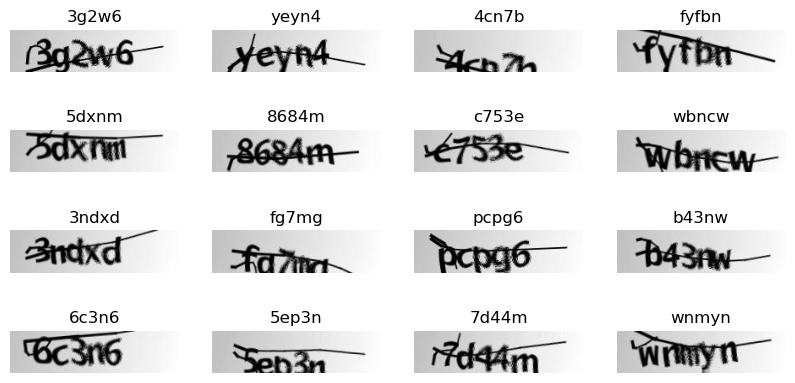

In [14]:

_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

# Model Architecture And CTC Loss 

In [21]:

def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    label_length = ops.cast(ops.squeeze(label_length, axis=-1), dtype="int32")
    input_length = ops.cast(ops.squeeze(input_length, axis=-1), dtype="int32")
    sparse_labels = ops.cast(
        ctc_label_dense_to_sparse(y_true, label_length), dtype="int32"
    )

    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())

    return ops.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length
        ),
        1,
    )


def ctc_label_dense_to_sparse(labels, label_lengths):
    label_shape = ops.shape(labels)
    num_batches_tns = ops.stack([label_shape[0]])
    max_num_labels_tns = ops.stack([label_shape[1]])

    def range_less_than(old_input, current_input):
        return ops.expand_dims(ops.arange(ops.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )

    init = ops.cast(tf.fill([1, label_shape[1]], 0), dtype="bool")
    dense_mask = tf.compat.v1.scan(
        range_less_than, label_lengths, initializer=init, parallel_iterations=1
    )
    dense_mask = dense_mask[:, 0, :]

    label_array = ops.reshape(
        ops.tile(ops.arange(0, label_shape[1]), num_batches_tns), label_shape
    )
    label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)

    batch_array = ops.transpose(
        ops.reshape(
            ops.tile(ops.arange(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
    indices = ops.transpose(
        ops.reshape(ops.concatenate([batch_ind, label_ind], axis=0), [2, -1])
    )

    vals_sparse = tf.compat.v1.gather_nd(labels, indices)

    return tf.SparseTensor(
        ops.cast(indices, dtype="int64"), 
        vals_sparse, 
        ops.cast(label_shape, dtype="int64")
    )


class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = ops.cast(ops.shape(y_true)[0], dtype="int64")
        input_length = ops.cast(ops.shape(y_pred)[1], dtype="int64")
        label_length = ops.cast(ops.shape(y_true)[1], dtype="int64")

        input_length = input_length * ops.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * ops.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred



def build_model():
    input_img = layers.Input(shape=(img_width, img_height, 1), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # ─── Conv Block 1 ───
    x = layers.Conv2D(32, (3, 3), padding="same", activation=None, kernel_initializer="he_normal", name="Conv1")(input_img)
    x = layers.BatchNormalization(name="bn1")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name="pool1")(x)

    # ─── Conv Block 2 ───
    x = layers.Conv2D(64, (3, 3), padding="same", activation=None, kernel_initializer="he_normal", name="Conv2")(x)
    x = layers.BatchNormalization(name="bn2")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name="pool2")(x)

    # ─── Conv Block 3 ───
    x = layers.Conv2D(256, (3, 3), padding="same", activation=None, kernel_initializer="he_normal", name="Conv3")(x)
    x = layers.BatchNormalization(name="bn3")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 1), name="pool3")(x)  # Height reduced, width preserved

    # ─── Reshape ───
    new_shape = (img_width // 4, (img_height // 8) * 256)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)

    # ─── Dense & Dropout ───
    x = layers.Dense(256, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.3)(x)

    # ─── RNN Stack ───
    x = layers.Bidirectional(
        layers.LSTM(192, return_sequences=True, dropout=0.25), name="bilstm1"
    )(x)
    x = layers.Bidirectional(
        layers.LSTM(128, return_sequences=True, dropout=0.25), name="bilstm2"
    )(x)

    # ─── Output ───
    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2")(x)

    # CTC loss layer
    output = CTCLayer(name="ctc_loss")(labels, x)

    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="ocr_model_balanced")
    model.compile(optimizer=keras.optimizers.Adam())
    return model

# Get the model
model = build_model()
model.summary()

Model: "ocr_model_balanced"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 50,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 200, 50,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 200, 50,   │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 200, 50,   │          0 │ bn1[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 100, 25,   │          0 │ activation_9[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 100, 25,   │     18,496 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2                 │ (None, 100, 25,   │        256 │ Conv2[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 100, 25,   │          0 │ bn2[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 50, 12,    │          0 │ activation_10[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv3 (Conv2D)      │ (None, 50, 12,    │    147,712 │ pool2[0][0]       │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn3                 │ (None, 50, 12,    │      1,024 │ Conv3[0][0]       │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 50, 12,    │          0 │ bn3[0][0]         │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool3               │ (None, 25, 12,    │          0 │ activation_11[0]… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 1536)  │          0 │ pool3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 50, 256)   │    393,472 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 50, 256)   │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm1             │ (None, 50, 384)   │    689,664 │ dropout_5[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm2             │ (None, 50, 256)   │    525,312 │ bilstm1[0][0]   

 Total params: 1,781,781 (6.80 MB)

 Trainable params: 1,781,077 (6.79 MB)

 Non-trainable params: 704 (2.75 KB)

## Training our 5000*0.9 images

In [22]:

# TODO restore epoch count.
epochs = 60
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)


Epoch 1/60


2025-07-05 17:23:15.421268: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 311.8572

2025-07-05 17:24:58.254904: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


293/293 ━━━━━━━━━━━━━━━━━━━━ 110s 352ms/step - loss: 311.7157 - val_loss: 259.5305
Epoch 2/60
293/293 ━━━━━━━━━━━━━━━━━━━━ 95s 325ms/step - loss: 258.9616 - val_loss: 254.6706
Epoch 3/60
293/293 ━━━━━━━━━━━━━━━━━━━━ 91s 309ms/step - loss: 255.1064 - val_loss: 253.9500
Epoch 4/60
293/293 ━━━━━━━━━━━━━━━━━━━━ 88s 299ms/step - loss: 254.3710 - val_loss: 252.1861
Epoch 5/60
293/293 ━━━━━━━━━━━━━━━━━━━━ 88s 300ms/step - loss: 251.3989 - val_loss: 260.4243
Epoch 6/60
293/293 ━━━━━━━━━━━━━━━━━━━━ 89s 302ms/step - loss: 247.2104 - val_loss: 244.7673
Epoch 7/60
293/293 ━━━━━━━━━━━━━━━━━━━━ 86s 292ms/step - loss: 240.9380 - val_loss: 226.5970
Epoch 8/60
293/293 ━━━━━━━━━━━━━━━━━━━━ 85s 291ms/step - loss: 225.6767 - val_loss: 213.5787
Epoch 9/60
293/293 ━━━━━━━━━━━━━━━━━━━━ 86s 294ms/step - loss: 210.8517 - val_loss: 203.3697
Epoch 10/60
293/293 ━━━━━━━━━━━━━━━━━━━━ 85s 291ms/step - loss: 197.4466 - val_loss: 191.2089
Epoch 11/60
293/293 ━━━━━━━━━━━━━━━━━━━━ 86s 295ms/step - loss: 185.4350 - val_

## Loss VS Epochs plot

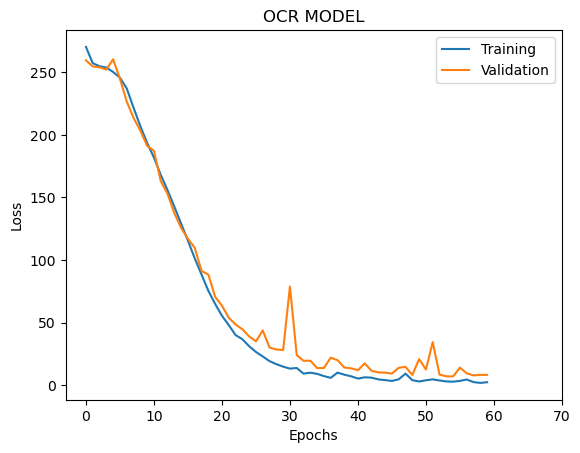

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xticks(range(0,74,10))
plt.title("OCR MODEL")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["Training","Validation"],loc="upper right")
plt.show()

## Inference in the validation dataset

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 50, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 200, 50, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 200, 50, 32)    │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 200, 50, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 25, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 100, 25, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 100, 25, 64)    │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 100, 25, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 50, 12, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 50, 12, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 50, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 25, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 1536)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 50, 256)        │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm1 (Bidirectional)         │ (None, 50, 384)        │       689,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm2 (Bidirectional)         │ (None, 50, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 50, 21)         │         5,397 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,781,781 (6.80 MB)

 Trainable params: 1,781,077 (6.79 MB)

 Non-trainable params: 704 (2.75 KB)

2025-07-05 19:09:36.271134: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


2025-07-05 19:09:38.641785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


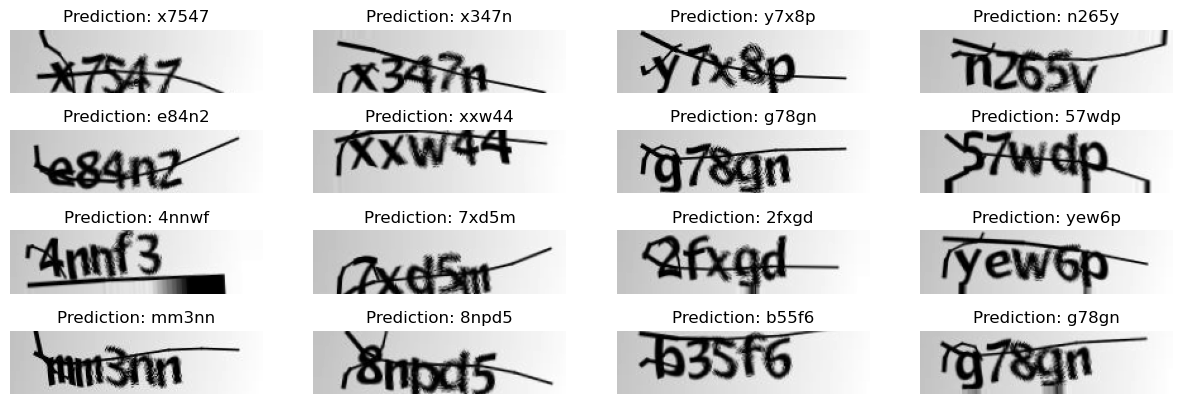

In [24]:

def ctc_decode(y_pred, input_length, greedy=True, beam_width=100, top_paths=1):
    input_shape = ops.shape(y_pred)
    num_samples, num_steps = input_shape[0], input_shape[1]
    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())
    input_length = ops.cast(input_length, dtype="int32")

    if greedy:
        (decoded, log_prob) = tf.nn.ctc_greedy_decoder(
            inputs=y_pred, sequence_length=input_length
        )
    else:
        (decoded, log_prob) = tf.compat.v1.nn.ctc_beam_search_decoder(
            inputs=y_pred,
            sequence_length=input_length,
            beam_width=beam_width,
            top_paths=top_paths,
        )
    decoded_dense = []
    for st in decoded:
        st = tf.SparseTensor(st.indices, st.values, (num_samples, num_steps))
        decoded_dense.append(tf.sparse.to_dense(sp_input=st, default_value=-1))
    return (decoded_dense, log_prob)


# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.input[0], model.get_layer(name="dense2").output
)
prediction_model.summary()


# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

File : 22d5n_aug2.png
Pred : 22d5n
True : 22d5n


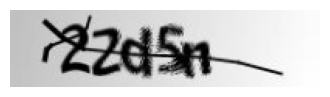

In [32]:
from pathlib import Path
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# -------- CONFIG -------------------------------------------------------------
img_path   = Path("./captcha_images_v2/22d5n_aug2.png")   # <-- your file
img_height = 50      # training height
img_width  = 200     # training width
transpose_for_model = True   # flip H<->W if that’s what you did in training
# -----------------------------------------------------------------------------


# ❶ Load + preprocess exactly like in training
def load_and_preprocess_image(path):
    img = tf.io.read_file(str(path))
    img = tf.io.decode_png(img, channels=1)          # grayscale
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    img = tf.image.resize(img, (img_height, img_width))
    if transpose_for_model:                          # match model orientation
        img = tf.transpose(img, perm=[1, 0, 2])      # (W,H,C)
    return img

single_img = tf.expand_dims(load_and_preprocess_image(img_path), axis=0)  # (1, …)

# ❷ Forward pass → logits
y_pred = prediction_model(single_img, training=False).numpy()

# ❸ Decode (greedy CTC here; set greedy=False, beam_width=10 for beam search)
pred_text = decode_batch_predictions(y_pred)[0]

# ❹ Show results
print("File :", img_path.name)
print("Pred :", pred_text)

true_label = img_path.stem.split("_aug")[0]  # strip "_augN" if present
print("True :", true_label)                  # optional

# Display the image *below* the text
plt.figure(figsize=(4, 2))
img_to_show = single_img[0, :, :, 0]         # remove batch & channel dims
if transpose_for_model:                      # undo transpose for viewing
    img_to_show = tf.transpose(img_to_show)
plt.imshow(img_to_show, cmap='gray')
plt.axis("off")
plt.show()


In [5]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


In [4]:
!pip install tensorflow-macos
!pip install tensorflow-metal


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
